# Валидация на отложеннной скважине

In [1]:
import os
import sys
import glob

sys.path.insert(0, os.path.join("..", "..", ".."))

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import PIL
from PIL import Image

from well_logs import CoreBatch
from well_logs.batchflow import Dataset, Pipeline, B, V, FilesIndex
from well_logs.batchflow.models.torch import ResNet18
from utils import make_data, show_images, assemble, assemble_stat

Загрузим разметку для отложенной скважины

In [2]:
comments = pd.read_csv('/notebooks/data/test_dataset/503/samples.csv').set_index('SAMPLE')

In [3]:
PATH = '/notebooks/data/test_dataset/503'

index = FilesIndex(path=os.path.join(PATH, 'samples_dl/*.png'))

## Предобработка

In [4]:
df = pd.concat([pd.read_feather(filename) for filename in glob.glob(PATH+'/samples.feather')])
df['QC'] = 1 - df['QC']
df = df.set_index('SAMPLE')

In [5]:
index = index.create_subset(np.intersect1d(df.index.values, index.indices))
ds = Dataset(index, CoreBatch)

In [6]:
SHAPE = (2, 400, 150)

In [7]:
shape_ppl = (ds.p
     .load(df=df)
     .check_shapes()
     .init_variable('quality', init_on_each_run=list)
     .update_variable('quality', B('check'), mode='e')
     .init_variable('shape1', init_on_each_run=list)
     .update_variable('shape1', B('s1'), mode='e') 
     .init_variable('shape2', init_on_each_run=list)
     .update_variable('shape2', B('s2'), mode='e')
     .run(batch_size=10, n_epochs=1, shuffle=False, drop_last=False, lazy=True, bar=False)
    )

shape_ppl.run()

mask = np.array(shape_ppl.get_variable('quality'))
ds.indices[mask]
np.array(shape_ppl.get_variable('shape1'))[mask]
np.array(shape_ppl.get_variable('shape2'))[mask]

shape_df = df.copy().loc[ds.indices]
shape_df['DL_SHAPE'] = shape_ppl.get_variable('shape1')
shape_df['UV_SHAPE'] = shape_ppl.get_variable('shape2')

shape_df.loc[ds.indices[np.array(shape_ppl.get_variable('quality'))]]

DEPTH_FROM  DEPTH_TO  QC     DL_SHAPE     UV_SHAPE
SAMPLE                                                                  
503_2967_2967.91.png      2967.0   2967.91   0  [259, 2298]  [259, 2299]

In [8]:
short_ppl = (ds.p
     .load(df=df)
     .short_cores(SHAPE[1:])
     .init_variable('short', init_on_each_run=list)
     .update_variable('short', B('short'), mode='e')
     .run(batch_size=10, n_epochs=1, shuffle=False, drop_last=False, lazy=True, bar=False)
    )

short_ppl.run()

long_index = ds.index.create_subset(
    ds.indices[np.logical_not(short_ppl.get_variable('short') or shape_ppl.get_variable('quality'))]
)

In [9]:
filtered_df = Dataset(long_index, CoreBatch)

In [10]:
well_stat = dict()

for well_path in glob.glob(PATH):
    well_stat[well_path] = {'dl': [], 'uv': []}
    for image in glob.glob(os.path.join(well_path, 'samples_uv', '*')):
        img = np.array(Image.open(image))
        well_stat[well_path]['uv'].append(img.flatten())
    for image in glob.glob(os.path.join(well_path, 'samples_dl', '*')):
        img = np.array(Image.open(image))
        well_stat[well_path]['dl'].append(img.flatten())
    well_stat[well_path]['dl'] = np.concatenate(well_stat[well_path]['dl'])
    well_stat[well_path]['uv'] = np.concatenate(well_stat[well_path]['uv'])

percentile = 90
bounds = dict()
for well in well_stat:
    bounds[well.split('/')[-1]] = {'dl': np.percentile(well_stat[well]['dl'], percentile),
                    'uv': np.percentile(well_stat[well]['uv'], percentile)}

In [11]:
bounds

{'503': {'dl': 165.0, 'uv': 17.0}}

In [12]:
load_ppl = (Pipeline().load(bw=True, df=df).normalize(bounds=bounds))

# Валидация

In [13]:
test_template = (Pipeline()
    .to_array(src='uv', dst='uv', channels='first')
    .to_array(src='dl', dst='dl', channels='first')
    .crop(SHAPE[1:], 200)
    .init_model('dynamic', ResNet18, 'model', config={
                    'device': 'gpu:2', 'load/path': 'resnet16.torch'
                })
    .init_variable('loss', init_on_each_run=list)
    .call(make_data, save_to=(B('crops_conc'), B('labels_crops_conc')))
    .init_variable('proba', init_on_each_run=None)
    .init_variable('metrics', init_on_each_run=None)
    .predict_model('model', B('crops_conc'), targets=B('labels_crops_conc'), fetches='proba',
                 save_to=B('proba', mode='w'))
    .call(assemble_stat, save_to=B('all_proba', mode='w'))
    .call(assemble, save_to=B('proba', mode='w'))
    .gather_metrics('class', targets=B('labels'), predictions=B('proba'),
                            fmt='proba', axis=-1, save_to=V('metrics', mode='u'), threshold=0.5)
    .init_variable('stat', init_on_each_run=list)
    .update_variable('stat', (B('dl'), B('uv'), B('proba'), B('labels')), mode='a')
    .run(
        batch_size=8,
        n_epochs=1,
        shuffle=False,
        drop_last=False,
        lazy=True,
        bar=True
    )
)

In [14]:
test_ppl = (load_ppl + test_template) << filtered_df

In [15]:
test_ppl.reset_iter()
test_ppl.run()

 97%|█████████▋| 31/32 [00:18<00:00,  2.02it/s]


In [16]:
stat = test_ppl.get_variable('stat')
dl_images = np.concatenate([item[0] for item in stat])
uv_images = np.concatenate([item[1] for item in stat])
proba = np.concatenate([item[2] for item in stat])
labels = np.concatenate([item[3] for item in stat])

In [29]:
threshold = 0.5

false_negative = [i for i in range(len(labels)) if (labels[i] == 1) & (proba[i][1] < threshold)]
false_positive = [i for i in range(len(labels)) if (labels[i] == 0) & (proba[i][1] > threshold)]

true_negative = [i for i in range(len(labels)) if (labels[i] == 0) & (proba[i][1] < threshold)]
true_positive = [i for i in range(len(labels)) if (labels[i] == 1) & (proba[i][1] > threshold)]  

In [30]:
print('TP:', len(true_positive))
print('TN:', len(true_negative))
print('FP:', len(false_positive))
print('FN:', len(false_negative))

TP: 5
TN: 174
FP: 62
FN: 9


Как мы видим, модель ошибается и часто относит небракованные пары к бракованным. Рассотрим изображения, на которых происходят ошибки

# False negative

Фото в uv смещено 


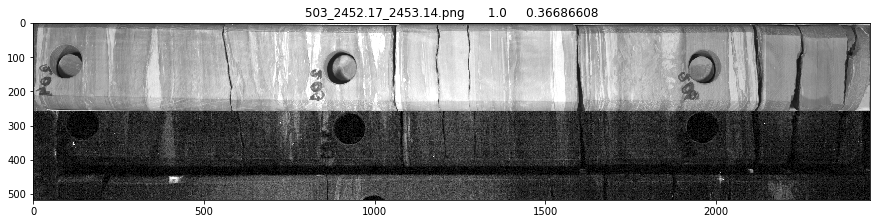

Фото в uv смещено 


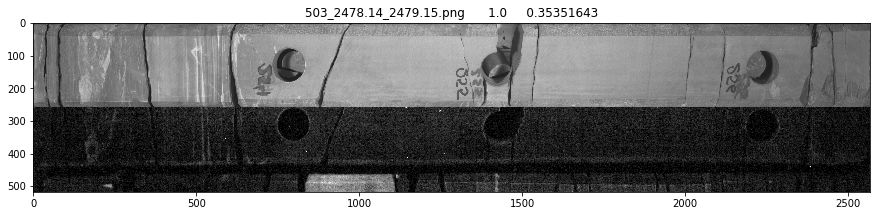

Фото в uv смещено 


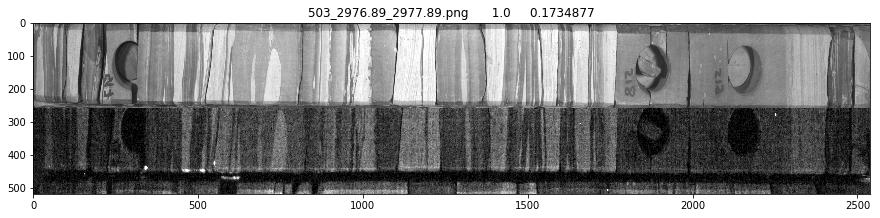

Фото в uv смещено 


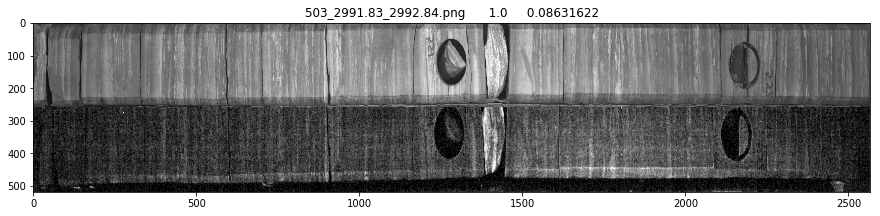

Фото в uv смещено 


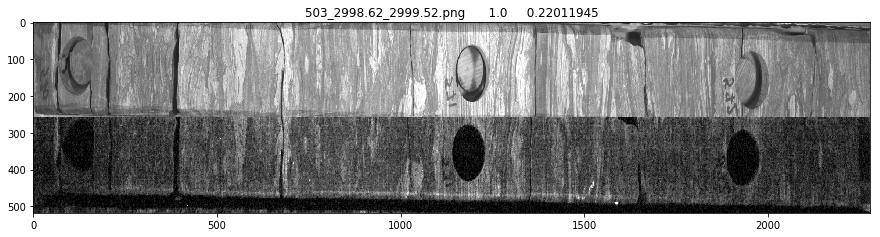

Фото в uv смещено 


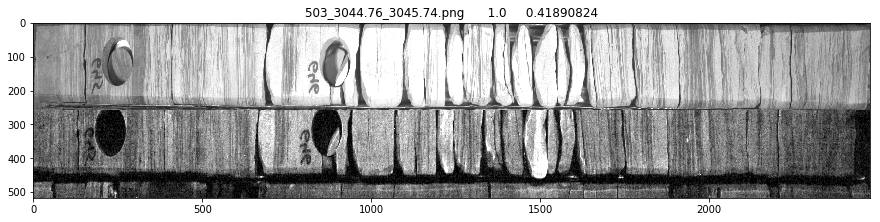

Фото в uv смещено 


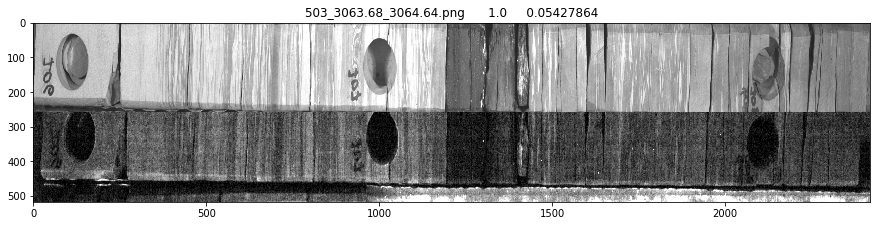

Фото в uv смещено 


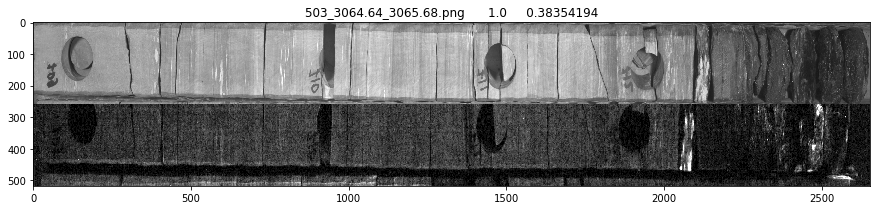

Фото в uv смещено 


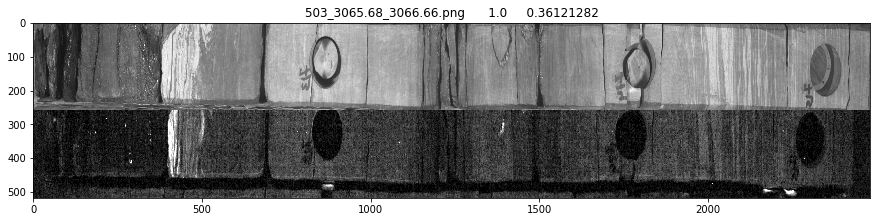

In [31]:
index = test_ppl.dataset.indices

for i in false_negative:
    img1 = np.squeeze(dl_images[i])
    img2 = np.squeeze(uv_images[i])
    img1[img1 > 1] = 1
    img2[img2 > 1] = 1
    shape = np.min((img1.shape[0], img2.shape[0])), np.min((img1.shape[1], img2.shape[1]))
    print(comments.loc[index[i]].COMMENT)
    plt.figure(figsize=(15,10))
    plt.imshow(np.concatenate((img1[:shape[0],:shape[1]], img2[:shape[0],:shape[1]]), axis=1).transpose(), cmap='gray')
    plt.title(index[i] + '      ' + str(labels[i]) + '     ' + str(proba[i][1]))
    plt.show()

# False positive

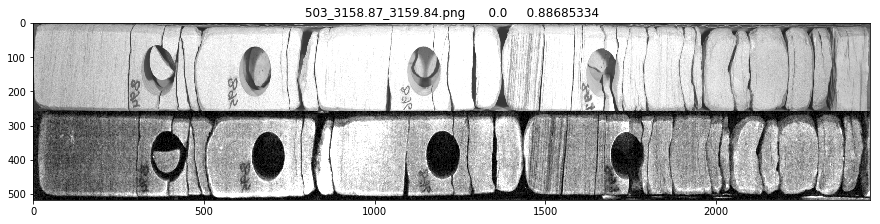

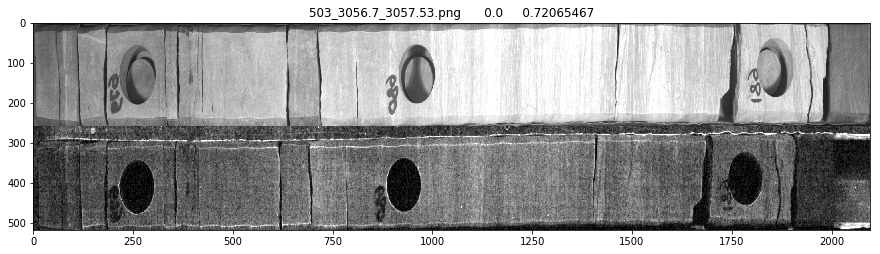

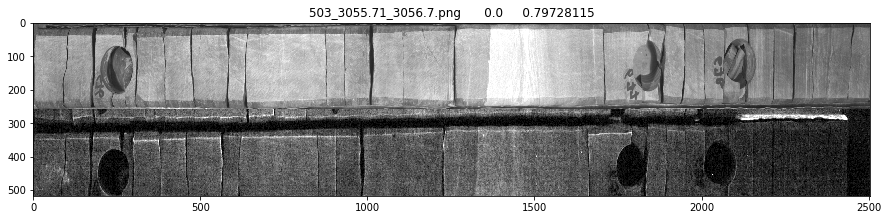

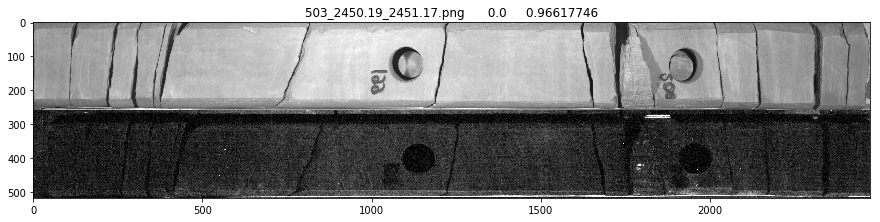

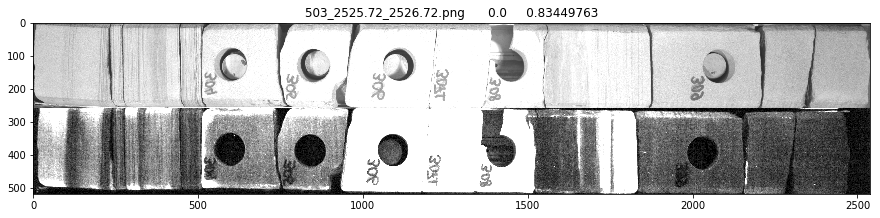

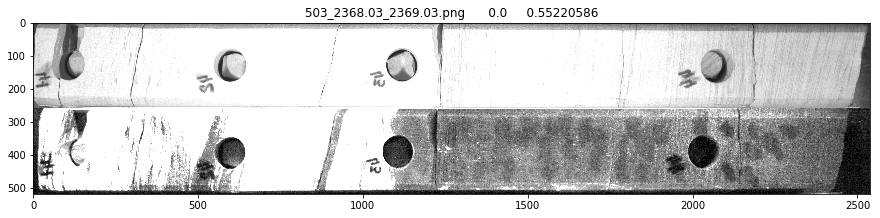

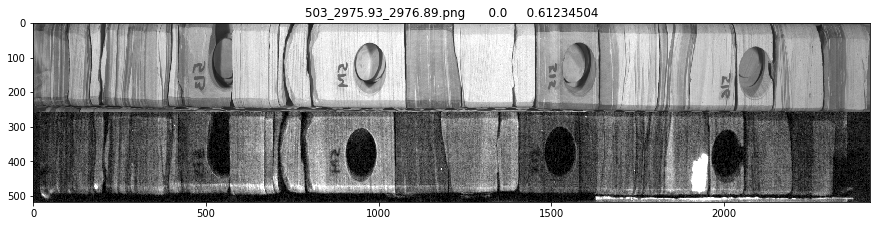

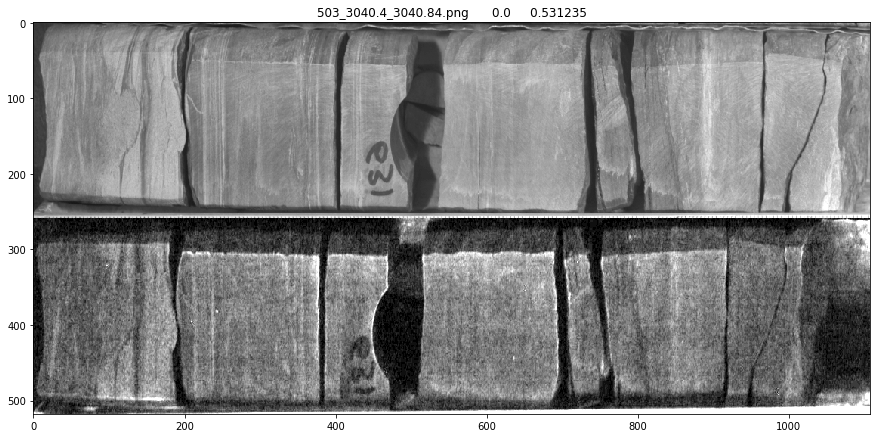

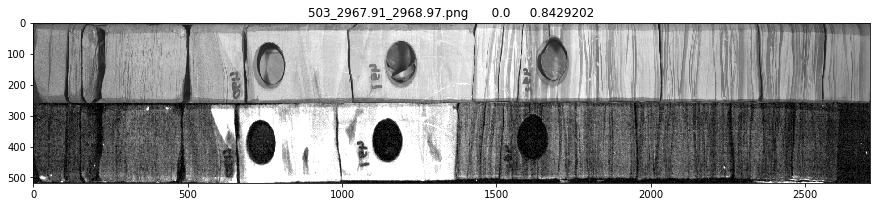

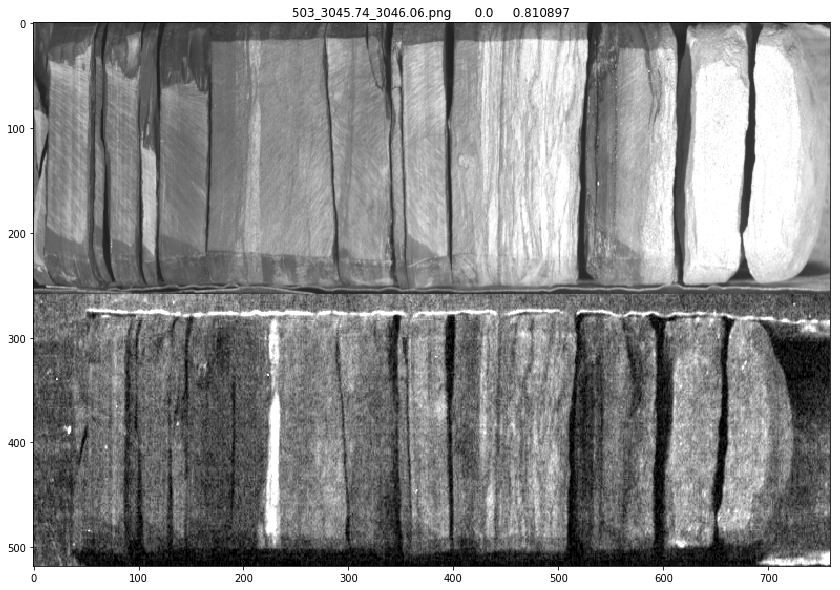

In [34]:
for i in np.random.choice(false_positive, 10,  replace=False):
    img1 = np.squeeze(dl_images[i])
    img2 = np.squeeze(uv_images[i])
    img1[img1 > 1] = 1
    img2[img2 > 1] = 1
    shape = np.min((img1.shape[0], img2.shape[0])), np.min((img1.shape[1], img2.shape[1]))
    plt.figure(figsize=(15,10))
    plt.imshow(np.concatenate((img1[:shape[0],:shape[1]], img2[:shape[0],:shape[1]]), axis=1).transpose(), cmap='gray')
    plt.title(index[i] + '      ' + str(labels[i]) + '     ' + str(proba[i][1]))
    plt.show()

Несоответствие фотографий в dl и uv 


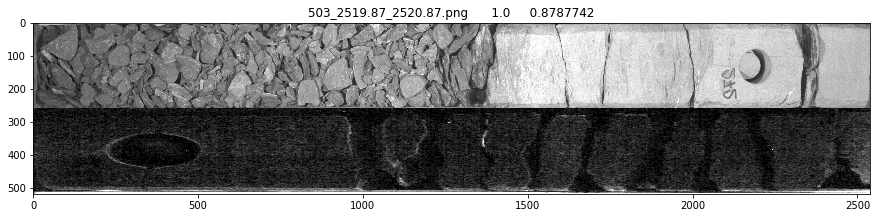

Фото в uv обрезано сверху


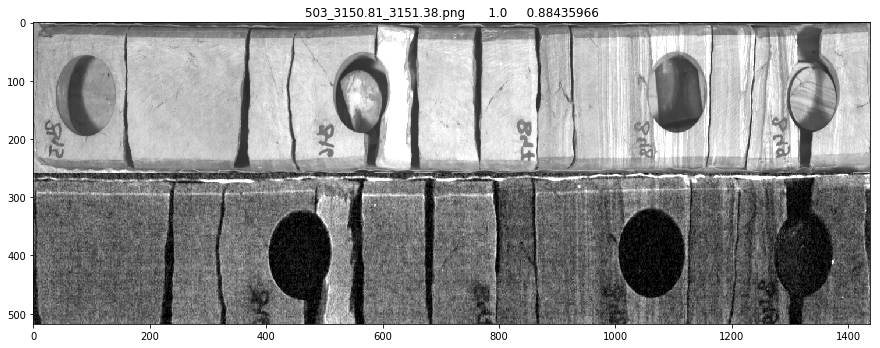

Фото в uv смещено 


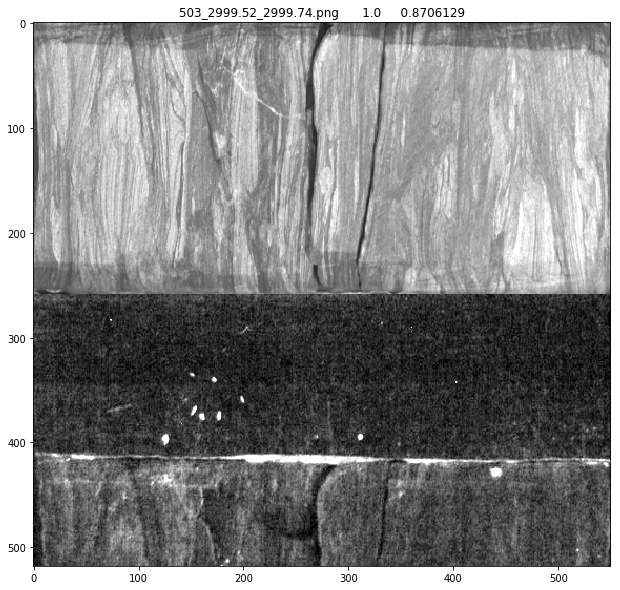

Фото в uv смещено 


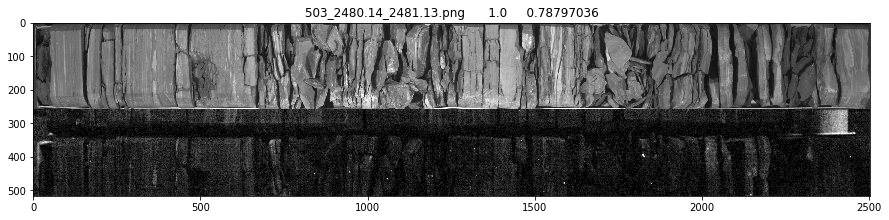

Несоответствие фотографий в dl и uv 


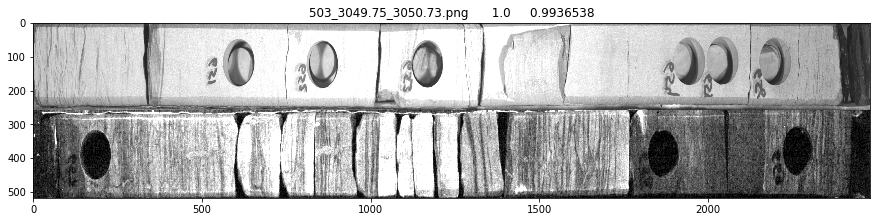

In [37]:
for i in np.random.choice(true_positive, min(10, len(true_positive)), replace=False):
    img1 = np.squeeze(dl_images[i])
    img2 = np.squeeze(uv_images[i])
    img1[img1 > 1] = 1
    img2[img2 > 1] = 1
    shape = np.min((img1.shape[0], img2.shape[0])), np.min((img1.shape[1], img2.shape[1]))
    print(comments.loc[index[i]].COMMENT)
    plt.figure(figsize=(15,10))
    plt.imshow(np.concatenate((img1[:shape[0],:shape[1]], img2[:shape[0],:shape[1]]), axis=1).transpose(), cmap='gray')
    plt.title(index[i] + '      ' + str(labels[i]) + '     ' + str(proba[i][1]))
    plt.show()

# Вывод

Модель срабатывает в случаях, когда фотографии сдвинуты по вертикали относительно друг друга, а такие пары в разметке не относятся к бракованным.